# Software profesional en Acústica 2024-25 (M2i)

*This notebook contains a modification of the notebook [FEM_Helmholtz_equation_Robin](https://github.com/spatialaudio/computational_acoustics/blob/master/FEM_Helmholtz_equation_Robin.ipynb), created by Sascha Spors, Frank Schultz, Computational Acoustics Examples, 2018. The text/images are licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/). The code is released under the [MIT license](https://opensource.org/licenses/MIT).*

First, we need to install on the fly FEniCS 2019.1.0 using the [FEM on Colab](https://fem-on-colab.github.io/packages.html) install script:

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# Numerical Solution of the Helmholtz Equation with Robin Boundary Conditions using the Finite Element Method

This notebook illustrates the numerical solution of the wave equation for an harmonic excitation and Robin boundary conditions using the [Finite Element Method](https://en.wikipedia.org/wiki/Finite_element_method) (FEM). The method aims at an approximate solution by subdividing the area of interest into smaller parts with simpler geometry, linking these parts together and applying methods from the calculus of variations to solve the problem numerically. The FEM is a well established method for the numerical approximation of the solution of partial differential equations (PDEs). The solutions of PDEs are often known analytically only for rather simple geometries. FEM based simulations allow to gain insights into other more complex cases.

## Problem Statement

The inhomogeneous [Helmholtz equation](https://en.wikipedia.org/wiki/Helmholtz_equation) is given as

\begin{equation*}
\Delta P(\boldsymbol{x}, \omega) + \frac{\omega^2}{c^2} P(\boldsymbol{x}, \omega) = - F(\boldsymbol{x}, \omega) .
\end{equation*}

We aim for a numerical solution of the Helmholtz equation on the domain $\Omega$ with respect to the homogeneous Robin boundary condition

\begin{equation*}
V_n(\boldsymbol{x}, \omega) + \frac{1}{Z(\boldsymbol{x}, \omega)} P(\boldsymbol{x}, \omega) = 0 \qquad \text{for } \boldsymbol{x} \in \partial \Omega,
\end{equation*}

where $V_n(\boldsymbol{x}, \omega)$ denotes the particle velocity in inward normal direction to the boundary $\partial \Omega$ of $\Omega$ and $Z(\boldsymbol{x}, \omega)$ the surface impedance of the boundary.
The particle velocity can be linked to the pressure using the Euler equation

\begin{equation*}
-\mathrm{j} \omega \rho_0 V_n(\boldsymbol{x}, \omega) = \frac{\partial}{\partial n} P(\boldsymbol{x}, \omega) ,
\end{equation*}

where $\rho_0$ denotes the mass density of air.
Introducing this into the Robin boundary equation above yields

\begin{equation*}
\frac{\partial}{\partial n} P(\boldsymbol{x}, \omega) - \mathrm{j} \underbrace{\frac{\omega \rho_0}{Z}}_{\sigma} P(\boldsymbol{x}, \omega) = 0 \qquad \text{for } \boldsymbol{x} \in \partial \Omega .
\end{equation*}

The medium impedance of air for free-field propagation is $Z_0 = \rho_0 c$, hence $\sigma_0 = \frac{\omega}{c}$ in this case. Free-field conditions can be simulated by matching the impedance of the boundary to $Z_0$.

## Variational Formulation

Starting from the [variational formulation of the Helmholtz equation](FEM_Helmholtz_equation_2D.ipynb#Variational-Formulation) (before application of Green's first theorem)

\begin{equation*}
{-} \int_\Omega \nabla P(\boldsymbol{x}, \omega) \cdot \nabla Q(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{x}  + \int_{\partial \Omega} Q(\boldsymbol{x}, \omega) \frac{\partial}{\partial n}  P(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{s} + \frac{\omega^2}{c^2} \int_\Omega P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{x} = -\int_\Omega F(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{x}
\end{equation*}

and introducing the Robin boundary condition into the second integral yields

\begin{equation*}
{-} \int_\Omega \nabla P(\boldsymbol{x}, \omega) \cdot \nabla Q(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{x}  + \mathrm{j} \sigma \int_{\partial \Omega} Q(\boldsymbol{x}, \omega) P(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{s} + \frac{\omega^2}{c^2} \int_\Omega P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{x} = -\int_\Omega F(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{x} .
\end{equation*}

It is common to express this integral equation in terms of the bilinear $a(P, Q)$ and linear $L(Q)$ forms 

\begin{equation*}
a(P, V) = \frac{\omega^2}{c^2} \int_\Omega P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{x} - \int_\Omega \nabla P(\boldsymbol{x}, \omega) \cdot \nabla Q(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{x} + \mathrm{j} \sigma \int_{\partial \Omega} Q(\boldsymbol{x}, \omega) P(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{s} , \end{equation*}

\begin{equation*}
L(V) = -\int_\Omega Q(\boldsymbol{x}, \omega) F(\boldsymbol{x}, \omega)\, \mathrm{d}\boldsymbol{x} ,
\end{equation*}

where

\begin{equation*}
a(P, Q) = L(Q) \qquad \forall Q.
\end{equation*}

Computational implementations of the FEM (like FEniCS) may not be able to handle complex numbers.
In this case the problem can be split into two coupled problems with respect to the real and imaginary part. By introducing $P(\boldsymbol{x}, \omega) = P_r(\boldsymbol{x}, \omega) + \mathrm{j} P_i(\boldsymbol{x}, \omega)$ and $Q(\boldsymbol{x}, \omega) = Q_r(\boldsymbol{x}, \omega) + \mathrm{j} Q_i(\boldsymbol{x}, \omega)$ and identifying the real and imaginary parts of the bilinear and linear forms, we get

\begin{equation*}
a_r = \int_\Omega \left( \frac{\omega^2}{c^2} Q_r(\boldsymbol{x}, \omega) P_r(\boldsymbol{x}, \omega) -  \frac{\omega^2}{c^2} Q_i(\boldsymbol{x}, \omega) P_i(\boldsymbol{x}, \omega) - \nabla P_r(\boldsymbol{x}, \omega) \cdot \nabla Q_r(\boldsymbol{x}, \omega) + \nabla P_i(\boldsymbol{x}, \omega) \cdot \nabla Q_i(\boldsymbol{x}, \omega) \right)\, \mathrm{d}\boldsymbol{x} -
\sigma \cdot \int_{\partial \Omega} \left( Q_i(\boldsymbol{x}, \omega) P_r(\boldsymbol{x}, \omega) + Q_r(\boldsymbol{x}, \omega) P_i(\boldsymbol{x}, \omega) \right)\, \mathrm{d}\boldsymbol{s}, 
\end{equation*}

\begin{equation*}
a_i = \int_\Omega \left( \frac{\omega^2}{c^2} Q_r(\boldsymbol{x}, \omega) P_i(\boldsymbol{x}, \omega) +  \frac{\omega^2}{c^2} Q_i(\boldsymbol{x}, \omega) P_r(\boldsymbol{x}, \omega) - \nabla P_i(\boldsymbol{x}, \omega) \cdot \nabla Q_r(\boldsymbol{x}, \omega) + \nabla P_r(\boldsymbol{x}, \omega) \cdot \nabla Q_i(\boldsymbol{x}, \omega) \right)\, \mathrm{d}\boldsymbol{x} +
\sigma \cdot \int_{\partial \Omega} \left( Q_r(\boldsymbol{x}, \omega) P_r(\boldsymbol{x}, \omega) - Q_i(\boldsymbol{x}, \omega) P_i(\boldsymbol{x}, \omega) \right)\, \mathrm{d}\boldsymbol{s}
\end{equation*}

for the bilinear form.

## Numerical Solution

The numerical solution of the variational problem is based on [FEniCS](https://fenicsproject.org/), an open-source framework for numerical solution of PDEs.
Its high-level Python interface `dolfin` is used in the following to define the problem and compute the solution.
The implementation is based on the variational formulation derived above.
It is common in the FEM to denote the solution of the problem by $u$ and the test function by $v$.
The definition of the problem in FEniCS is very close to the mathematical formulation of the problem.

For the subsequent examples the solution of inhomogeneous wave equation for a point source $F(\boldsymbol{x}) = \delta(\boldsymbol{x}-\boldsymbol{x}_s)$ at position $\boldsymbol{x}_s$ is computed using the FEM.
A function is defined for this purpose, as well as for the plotting of the resulting sound field.

In [ ]:
import dolfin
import mshr
import matplotlib.pyplot as plt


def Helmholtz_Robin(mesh, frequency, xs, sigma=dolfin.Constant(0), c=343):
    
    # squared wavenumber
    k2 = dolfin.Constant(2*dolfin.pi*frequency/c)**2
    
    # define function space
    V = dolfin.VectorFunctionSpace(mesh, "CG", 1, dim=2)

    # define variational problem
    (u_r, u_i) = dolfin.TrialFunction(V)
    (Q_r, Q_i) = dolfin.TestFunction(V)

    a_r = ( k2 * dolfin.inner(u_r,Q_r) - k2 * dolfin.inner(u_i,Q_i) - dolfin.inner(dolfin.grad(u_r), dolfin.grad(Q_r)) + dolfin.inner(dolfin.grad(u_i), dolfin.grad(Q_i)) ) * dolfin.dx  - sigma*dolfin.inner(u_r, Q_i) * dolfin.ds - sigma*dolfin.inner(u_i, Q_r) * dolfin.ds
    a_i = ( k2 * dolfin.inner(u_r,Q_i) + k2 * dolfin.inner(u_i,Q_r) - dolfin.inner(dolfin.grad(u_r), dolfin.grad(Q_i)) - dolfin.inner(dolfin.grad(u_i), dolfin.grad(Q_r)) ) * dolfin.dx  + sigma*dolfin.inner(u_r, Q_r) * dolfin.ds - sigma*dolfin.inner(u_i, Q_i) * dolfin.ds
    L_r = dolfin.Constant(0) * Q_r * dolfin.dx
    L_i = dolfin.Constant(0) * Q_i * dolfin.dx

    a = a_r + a_i
    L = L_r + L_i
    A, b = dolfin.assemble_system(a, L)

    # define inhomogenity
    delta = dolfin.PointSource(V.sub(0), xs, -1)  # negative amplitude accounts for -Q(x,w) in inhomogeneous wave equation
    delta.apply(b)

    # compute solution
    u = dolfin.Function(V)
    dolfin.solve(A, u.vector(), b)
    (u_r, u_i) = dolfin.split(u)
    
    return u_r


def plot_soundfield(u):
    '''plots solution of FEM-based simulation'''
    fig = plt.figure(figsize=(10,10))
    fig = dolfin.plot(u)
    plt.title(r'$P(\mathbf{x}, \omega)$')
    plt.xlabel(r'$x$ in m')
    plt.ylabel(r'$y$ in m')
    plt.colorbar(fig, fraction=0.038, pad=0.04);

### Sound Field in a Rectangular Room

The two-dimensional sound field in a rectangular room (rectangular plate) with homogeneous Robin boundary conditions is computed for the frequency $f=120$ Hz and source position $x_s = (1.2,3.2)$ m.

In [2]:
f = 120  # frequency
xs = dolfin.Point(1.2, 3.2)  # source position

# define geometry and mesh
mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(5, 4), 200, 200, "right/left")

First, the case of sound-hard (Neumann) boundary conditions with $\sigma = 0$ ($Z \to \infty$) is considered.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


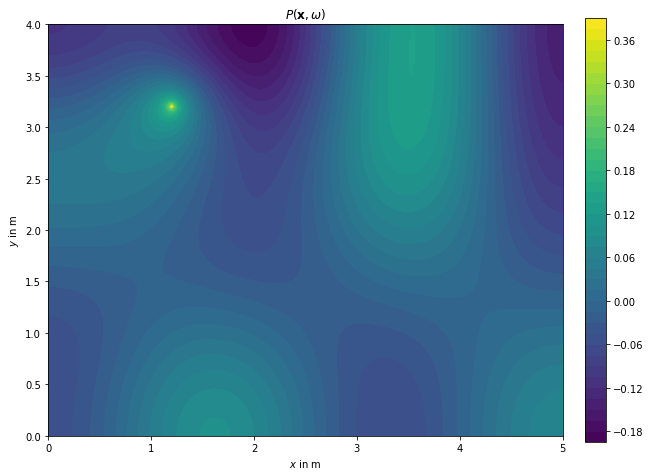

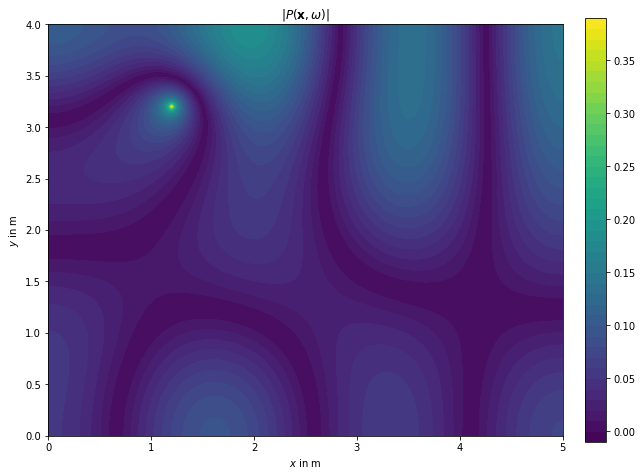

In [ ]:
# compute solution for sigma=0
u = Helmholtz_Robin(mesh, f, xs, sigma=dolfin.Constant(0))

# plot sound field
plot_soundfield(u)
plot_soundfield(abs(u))
plt.title(r'$|P(\mathbf{x}, \omega)|$');

Now the case of a matched boundary (free-field propagation) with $\sigma = \frac{\omega}{c}$ ($Z = Z_0$) is considered.

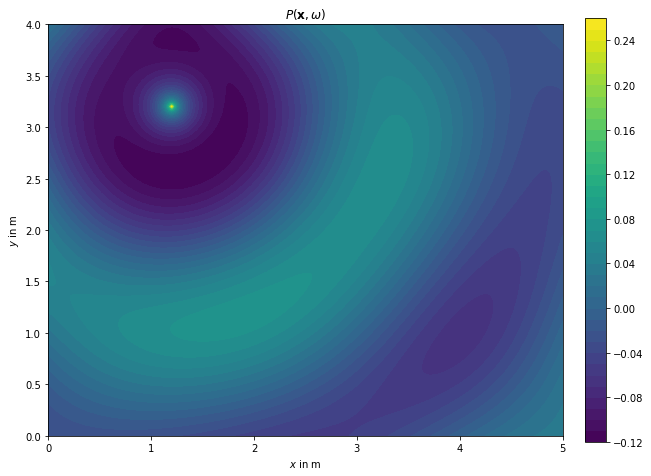

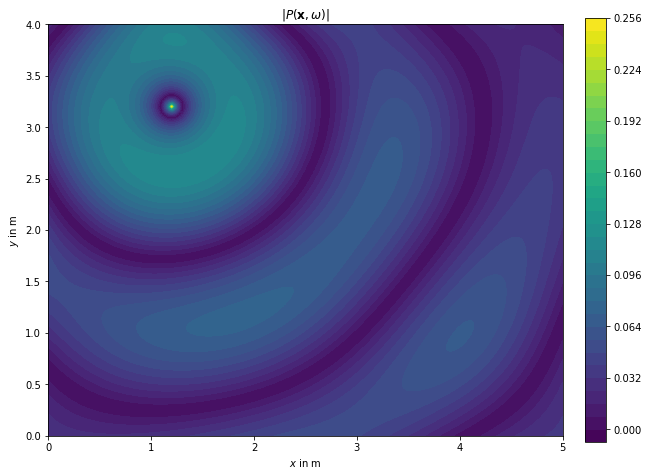

In [ ]:
# compute solution for free-field propogation
u = Helmholtz_Robin(mesh, f, xs, sigma=dolfin.Constant(2*dolfin.pi*f/343))

# plot sound field
plot_soundfield(u)
plot_soundfield(abs(u))
plt.title(r'$|P(\mathbf{x}, \omega)|$');

The last example shows the simulation result for sound-soft (Dirichlet) boundary conditions with $\sigma \to \infty$ ($Z=0$).

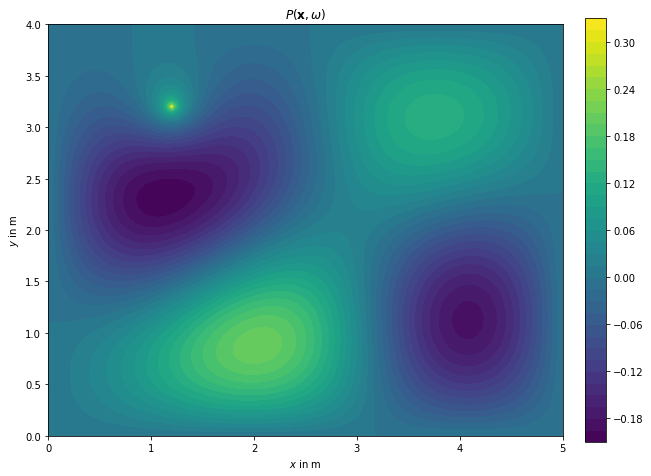

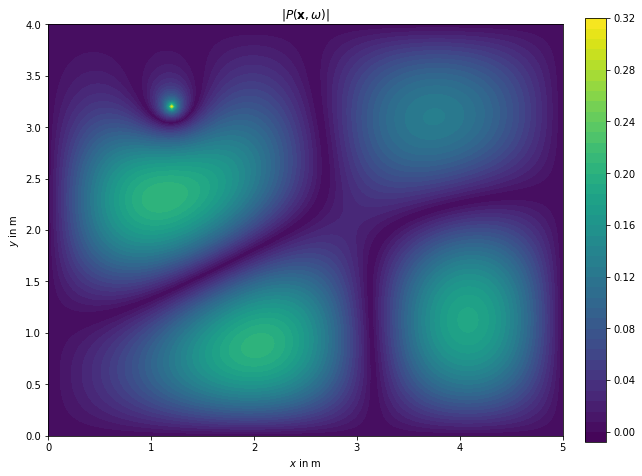

In [ ]:
# compute solution for very large sigma
u = Helmholtz_Robin(mesh, f, xs, sigma=dolfin.Constant(1e15))

# plot sound field
plot_soundfield(u)
plot_soundfield(abs(u))
plt.title(r'$|P(\mathbf{x}, \omega)|$');

The effect of the homogeneous Dirichlet boundary condition (zero pressure at the boundary) can be observed conveniently by inspecting the magnitude of the sound field close to the boundary.

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).